# Promis dataset preprocessing
### Import

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append('../')
from data_utils.preprocessing_utilities import stat_unique, remove_duplicates, densify,create_q2k, encode_attr, quadruplet_format, parse_data, split_data, save_to_csv,get_metadata, split_data_vertically,rescaling_dict,one_hot_encoding,split_small_data_vertically

import json
import pandas as pd
import numpy as np

In [3]:
raw_data = pd.read_csv('../1-raw_data/promis_flipped.csv', encoding="ISO-8859-15", low_memory=False)
raw_data = raw_data.drop(columns=['Unnamed: 0', 'Unnamed: 0.1'])
raw_data =  raw_data.rename(columns={"caseid": "user_id", "dimension_id":"supdimension_id", "subdimension_id":"dimension_id","question_id":"item_id"})
raw_data.head()

,user_id,item_id,correct,supdimension_id,dimension_id
0,84,EDANG55,NaN,Emotional Distress,Anger Items
1,85,EDANG55,NaN,Emotional Distress,Anger Items
2,86,EDANG55,NaN,Emotional Distress,Anger Items
3,87,EDANG55,NaN,Emotional Distress,Anger Items
4,88,EDANG55,NaN,Emotional Distress,Anger Items


In [4]:
print(len(raw_data))
all_data = raw_data.dropna()
print(len(all_data))

21957187
2256115


In [5]:
stat_unique(all_data, None)
stat_unique(all_data, ['user_id', 'item_id'])
stat_unique(all_data, 'user_id')
stat_unique(all_data, 'item_id')
stat_unique(all_data, 'dimension_id')
stat_unique(all_data, 'supdimension_id')

Total length: 2256115
Number of unique [user_id,item_id]: 2256115
Number of unique user_id: 21096
Number of unique item_id: 941
Number of unique dimension_id: 29
Number of unique supdimension_id: 6


### Clean Nan values

In [6]:
cleaned_data = all_data.dropna(subset=['user_id','item_id','dimension_id','correct', 'supdimension_id'], axis='index')

### Remove duplicated user and id rows

In [7]:
unduplicated_data = remove_duplicates(cleaned_data,key_attrs=['user_id','item_id','dimension_id', 'supdimension_id'],agg_attrs=[])

### Filter Data

In [8]:
filtered_data_0 = unduplicated_data
filtered_q_nb = 1
filtered_u_nb = 0
filtered_d_nb = 0
filtered_subd_nb = 0
while filtered_q_nb!=0 or filtered_u_nb!=0 or filtered_d_nb!=0 or filtered_subd_nb!=0: 
    # filter items
    filtered_data_1, filtered_q_nb = densify(filtered_data_0,'item_id','user_id',1835)
    # filter users
    filtered_data_2, filtered_u_nb = densify(filtered_data_1,'user_id','item_id',102)
    # filter knowledges
    filtered_data_3, filtered_d_nb = densify(filtered_data_2,'dimension_id','item_id',1)
    # filter knowledges
    filtered_data_4, filtered_subd_nb = densify(filtered_data_3,'supdimension_id','item_id',1)
    filtered_data_0 = filtered_data_4
    
stat_unique(filtered_data_0, None)
stat_unique(filtered_data_0, ['user_id', 'item_id'])
stat_unique(filtered_data_0, 'user_id')
stat_unique(filtered_data_0, 'item_id')
stat_unique(filtered_data_0, 'dimension_id')
stat_unique(filtered_data_0, 'supdimension_id')

filter 151 item_id
filter 4217 user_id
filter 0 dimension_id
filter 0 supdimension_id
filter 0 item_id
filter 0 user_id
filter 0 dimension_id
filter 0 supdimension_id
Total length: 1805842
Number of unique [user_id,item_id]: 1805842
Number of unique user_id: 16879
Number of unique item_id: 790
Number of unique dimension_id: 15
Number of unique supdimension_id: 6


### Encoding

In [9]:
# renumber the users
u_enc_data, u2n = encode_attr(filtered_data_0, "user_id")

In [10]:
# renumber the items
q_enc_data, q2n = encode_attr(u_enc_data, "item_id")

In [11]:
# renumber the dimensions
d_enc_data, d2n = encode_attr(q_enc_data, "dimension_id")

In [12]:
# renumber the subdimensions
sd_enc_data, sd2n = encode_attr(d_enc_data, "supdimension_id")

### Maps creation

In [13]:
q2k, k2q = create_q2k(sd_enc_data)

### Rescaling responses

In [14]:
# Create an empty dictionary to store the item ID and response range
promis_metadata = pd.read_csv("promis_complete_metadata.csv")

[response_range_dict, min_response_dict, max_response_dict] = rescaling_dict(promis_metadata,q2n)

'clinic01' were removed from dataset
'clinic02' were removed from dataset
'clinic03' were removed from dataset
'clinic04' were removed from dataset
'clinic05' were removed from dataset
'clinic06' were removed from dataset
'clinic07' were removed from dataset
'clinic08' were removed from dataset
'clinic09' were removed from dataset
'clinic10' were removed from dataset
'clinic11' were removed from dataset
'clinic12' were removed from dataset
'clinic14' were removed from dataset
'clinic15' were removed from dataset
'clinic16' were removed from dataset
'clinic17' were removed from dataset
'clinic18' were removed from dataset
'clinic19' were removed from dataset
'clinic20' were removed from dataset
'clinic119' were removed from dataset
'clinic120' were removed from dataset
'clinic21' were removed from dataset
'clinic22' were removed from dataset
'clinic23' were removed from dataset
'clinic24' were removed from dataset
'clinic25' were removed from dataset
'clinic26' were removed from dataset

In [15]:
sd_enc_data['correct'] = sd_enc_data.apply(lambda x : (x['correct']-min_response_dict[x['item_id']])/response_range_dict[x['item_id']]+1, axis=1 )
scaled_data = sd_enc_data
print(f'min value : {scaled_data["correct"].min()}, max value : {scaled_data["correct"].max()}')

min value : 1.0, max value : 2.0


### Get final stats and create metadata

In [16]:
metadata = get_metadata(scaled_data,["user_id", "item_id", "dimension_id"])

In [17]:
stat_unique(scaled_data, None)
stat_unique(scaled_data, ['user_id', 'item_id'])
stat_unique(scaled_data, 'user_id')
stat_unique(scaled_data, 'item_id')
stat_unique(scaled_data, 'dimension_id')
stat_unique(scaled_data, 'correct')

scaled_data_dim_grouped_items = scaled_data.groupby("dimension_id")["item_id"].nunique()
scaled_data_dim_grouped_users = scaled_data.groupby("dimension_id")["user_id"].nunique()
print('#questions/category: {} & {} &  {}'.format(np.min(scaled_data_dim_grouped_items),int(np.round(np.mean(scaled_data_dim_grouped_items))),np.max(scaled_data_dim_grouped_items)))
print('#users/category: {} & {} &  {}'.format(np.min(scaled_data_dim_grouped_users),int(np.round(np.mean(scaled_data_dim_grouped_users))),np.max(scaled_data_dim_grouped_users)))

scaled_data_dim_grouped_items = scaled_data.groupby("item_id")["dimension_id"].nunique()
scaled_data_dim_grouped_users = scaled_data.groupby("item_id")["user_id"].nunique()
print('#categorys/question: {} & {} &  {}'.format(np.min(scaled_data_dim_grouped_items),int(np.round(np.mean(scaled_data_dim_grouped_items))),np.max(scaled_data_dim_grouped_items)))
print('#users/question: {} & {} &  {}'.format(np.min(scaled_data_dim_grouped_users),int(np.round(np.mean(scaled_data_dim_grouped_users))),np.max(scaled_data_dim_grouped_users)))

scaled_data_dim_grouped_items = scaled_data.groupby("user_id")["item_id"].nunique()
scaled_data_dim_grouped_users = scaled_data.groupby("user_id")["dimension_id"].nunique()
print('#questions/users: {} & {} &  {}'.format(np.min(scaled_data_dim_grouped_items),int(np.round(np.mean(scaled_data_dim_grouped_items))),np.max(scaled_data_dim_grouped_items)))
print('#categorys/users: {} & {} &  {}'.format(np.min(scaled_data_dim_grouped_users),int(np.round(np.mean(scaled_data_dim_grouped_users))),np.max(scaled_data_dim_grouped_users)))

Total length: 1805842
Number of unique [user_id,item_id]: 1805842
Number of unique user_id: 16879
Number of unique item_id: 790
Number of unique dimension_id: 15
Number of unique correct: 9
#questions/category: 6 & 53 &  56
#users/category: 12007 & 12348 &  16559
#categorys/question: 1 & 1 &  1
#users/question: 1839 & 2286 &  16558
#questions/users: 102 & 107 &  118
#categorys/users: 2 & 11 &  15


Text(0.5, 1.0, 'Distribution of Responses')

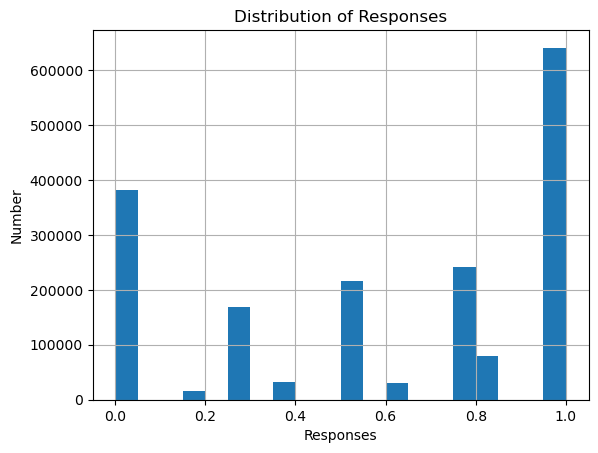

In [19]:
import matplotlib.pyplot as plt

# draw a histogram of the age column
(scaled_data['correct']-1).hist(bins=20)

# add labels and title
plt.xlabel('Responses')
plt.ylabel('Number')
plt.title('Distribution of Responses')


### Save data, concept map and metadata

In [42]:
# save selected data
scaled_data.to_csv('selected_data.csv', index=False)

In [43]:
# Convert int64 keys to a compatible type (e.g., int)
q2k_serializable = {str(key): value for key, value in q2k.items()}
# save concept map
with open('concept_map.json', 'w') as f:
    json.dump(q2k_serializable, f)

In [44]:
# save metadata
with open('metadata.json', 'w') as f:
    json.dump(metadata, f)

## parse data

In [45]:
quadruplet = quadruplet_format(scaled_data)

In [46]:
stu_data, ques_data = parse_data(scaled_data)

In [47]:
test_size = 0.2
valid_size = 0.2 # proportion over the all dataset
least_test_length=100

## Horizontal split

In [35]:
train_data, valid_data, test_data = split_data(quadruplet, stu_data, test_prop=test_size, valid_prop=valid_size, least_test_length=least_test_length) 

In [36]:
print(f'train records length: {len(train_data)}')
print(f'test records length: {len(test_data)}')
print(f'valid records length: {len(valid_data)}')
print(f'all records length: {len(train_data)+len(valid_data)+len(test_data)}')

## save row data

In [37]:
save_to_csv(train_data, '../2-preprocessed_data/promis_train_quadruples.csv')
save_to_csv(valid_data, '../2-preprocessed_data/promis_valid_quadruples.csv')
save_to_csv(test_data, '../2-preprocessed_data/promis_test_quadruples.csv')

## vertical split

In [48]:
train_data, valid_data, test_data = split_data_vertically(quadruplet, test_prop=test_size,valid_prop=valid_size, folds_nb=5)

In [49]:
for i_fold, train_fold in enumerate(train_data):
    save_to_csv(train_data[i_fold], f'../2-preprocessed_data/promis_train_quadruples_vert_{i_fold}.csv')
    save_to_csv(valid_data[i_fold], f'../2-preprocessed_data/promis_valid_quadruples_vert_{i_fold}.csv')
    save_to_csv(test_data[i_fold], f'../2-preprocessed_data/promis_test_quadruples_vert_{i_fold}.csv')

#### Toy dataset generation

In [50]:
train_data_small, valid_data_small, test_data_small = split_small_data_vertically(quadruplet, test_prop=0.8,valid_prop=0.1)

save_to_csv(train_data_small, f'../2-preprocessed_data/promis_small_train_quadruples_vert_{0}.csv')
save_to_csv(valid_data_small, f'../2-preprocessed_data/promis_small_valid_quadruples_vert_{0}.csv')
save_to_csv(test_data_small, f'../2-preprocessed_data/promis_small_test_quadruples_vert_{0}.csv')

### one hot encoding

In [93]:
train = pd.read_csv("../2-preprocessed_data/promis_train_quadruples.csv").astype({'student_id':int, 'item_id':int, "correct":float})
duplicated_train = one_hot_encoding(train,response_range_dict)
duplicated_train.to_csv('../2-preprocessed_data/promis_train_quadruples_ohe.csv', index=False)

FileNotFoundError: [Errno 2] No such file or directory: 'train_triples.csv'

In [ ]:
valid = pd.read_csv("../2-preprocessed_data/promis_valid_quadruples.csv").astype({'student_id':int, 'item_id':int, "correct":float})
duplicated_valid = one_hot_encoding(valid,response_range_dict)
duplicated_valid.to_csv('../2-preprocessed_data/promis_valid_quadruples_ohe.csv', index=False)

In [52]:
test = pd.read_csv("../2-preprocessed_data/promis_test_quadruples.csv")
duplicated_test = one_hot_encoding(test,response_range_dict)
duplicated_test.to_csv('../2-preprocessed_data/promis_test_quadruples_ohe.csv', index=False)

In [95]:
import numpy as np
import pandas as pd
from tqdm import tqdm

for i in range(5) : 
    train = pd.read_csv("../2-preprocessed_data/promis_train_quadruples_vert_"+str(i)+".csv").astype({'student_id':int, 'item_id':int, "correct":float})
    duplicated_train = one_hot_encoding(train,response_range_dict)
    duplicated_train.to_csv('../2-preprocessed_data/promis_train_quadruples_vert_ohe_'+str(i)+'.csv', index=False)
    
    valid = pd.read_csv("../2-preprocessed_data/promis_valid_quadruples_vert_"+str(i)+".csv").astype({'student_id':int, 'item_id':int, "correct":float})
    duplicated_valid = one_hot_encoding(valid,response_range_dict)
    duplicated_valid.to_csv('../2-preprocessed_data/promis_valid_quadruples_vert_ohe_'+str(i)+'.csv', index=False)
    
    test = pd.read_csv("../2-preprocessed_data/promis_test_quadruples_vert_"+str(i)+".csv").astype({'student_id':int, 'item_id':int, "correct":float})
    duplicated_test = one_hot_encoding(test,response_range_dict)
    duplicated_test.to_csv('../2-preprocessed_data/promis_test_quadruples_vert_ohe_'+str(i)+'.csv', index=False)

  2%|▏         | 18306/1136550 [00:06<07:02, 2648.90it/s]


IndexError: index 1 is out of bounds for axis 0 with size 1